## XGBoost single instrument - New input

This code uses the new input shape, using the librosa fourier and inverse fourier transform to generate the spectrograms from waveform

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Import external functions from the functions folder
import sys
sys.path.append('../../functions')
import functions as f

In [3]:
# Set local path to the folder containing the .wav audio files
path = 'C:/Users/lucvo/VScode/Machine_learning/Audio_data/nsynth-valid.jsonwav/nsynth-valid/audio/'

In [4]:
# Create a training set of spectrograms and labels
X, y, label_dict = f.create_single_inst_classification_set_new_input(N_samples=5000, classes=['keyboard','bass','flute', 'guitar'], path=path)

# Split the data into training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = f.split_data(X, y, val_frac=0.1, test_frac=0.1)

The dataset might be unbalanced


In [5]:
print(X_train.shape)
print(y_train.shape)
print(label_dict)

(4000, 129150)
(4000,)
{0: 'keyboard', 1: 'bass', 2: 'flute', 3: 'guitar'}


In [6]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix

In [7]:
# Use only the first 2000 samples for training
X_train = X_train[:1000]
y_train = y_train[:1000]

In [8]:
print(X_train.shape)
print(y_train.shape)
print(label_dict)

(1000, 129150)
(1000,)
{0: 'keyboard', 1: 'bass', 2: 'flute', 3: 'guitar'}


In [9]:
# Use an XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_dict), n_estimators=100, max_depth=3, learning_rate=0.1, n_jobs=-1)

# Train the model
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_set=eval_set, eval_metric='merror', early_stopping_rounds=10, verbose=True)

# Predict the labels of the validation set
y_pred = model.predict(X_val)

# Print the accuracy
accuracy = np.sum(y_pred == y_val) / len(y_val)
print('Accuracy:', accuracy)

c:\Users\lucvo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\lucvo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.14600	validation_1-merror:0.18000
[1]	validation_0-merror:0.09300	validation_1-merror:0.14200
[2]	validation_0-merror:0.06000	validation_1-merror:0.12800
[3]	validation_0-merror:0.05400	validation_1-merror:0.11600
[4]	validation_0-merror:0.04400	validation_1-merror:0.12200
[5]	validation_0-merror:0.04100	validation_1-merror:0.12800
[6]	validation_0-merror:0.04400	validation_1-merror:0.11800
[7]	validation_0-merror:0.03800	validation_1-merror:0.12000
[8]	validation_0-merror:0.03500	validation_1-merror:0.11000
[9]	validation_0-merror:0.03500	validation_1-merror:0.11200
[10]	validation_0-merror:0.03200	validation_1-merror:0.10800
[11]	validation_0-merror:0.02400	validation_1-merror:0.11000
[12]	validation_0-merror:0.02400	validation_1-merror:0.10400
[13]	validation_0-merror:0.02300	validation_1-merror:0.09400
[14]	validation_0-merror:0.01800	validation_1-merror:0.09000
[15]	validation_0-merror:0.01400	validation_1-merror:0.08800
[16]	validation_0-merror:0.01200	v

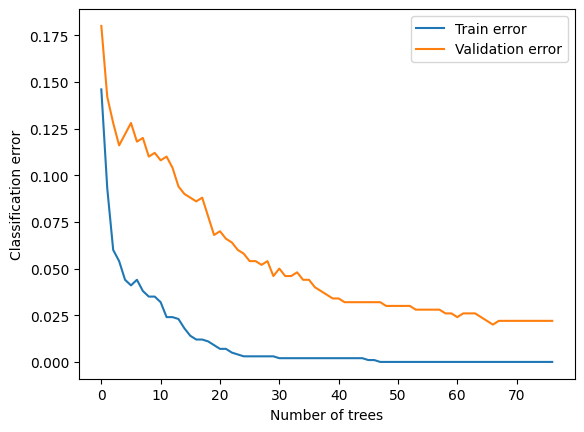

In [10]:
# Plot the training and validation error as a function of the number of trees
results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
n_trees = range(len(train_error))
plt.plot(n_trees, train_error, label='Train error')
plt.plot(n_trees, val_error, label='Validation error')
plt.xlabel('Number of trees')
plt.ylabel('Classification error')
plt.legend()
plt.show()

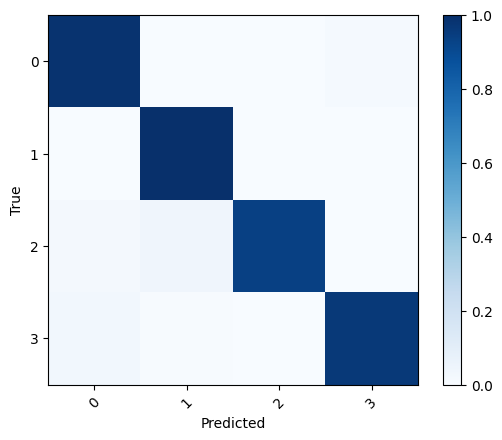

In [11]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
conf_normed = conf_matrix / np.sum(conf_matrix, axis=1)[:, np.newaxis]
plt.imshow(conf_normed, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(len(label_dict)), label_dict.keys(), rotation=45)
plt.yticks(range(len(label_dict)), label_dict.keys())
plt.show()

In [13]:
# Save the model and store in file
import pickle
with open('xgboost_model_new_iput.pkl', 'wb') as file:
    pickle.dump(model, file)